<a href="https://colab.research.google.com/github/Vikram125609/Optical-Mark-Recognition/blob/main/Optical_Mark_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import cv2 as cv2
from google.colab.patches import cv2_imshow

In [97]:
# getting all images
image1 = cv2.imread('/content/1.jpg')
image2 = cv2.imread('/content/2.jpg')
image3 = cv2.imread('/content/3.jpg')
image4 = cv2.imread('/content/MCQPaper.jpg')
image5 = cv2.imread('/content/Thumbnail.jpg')

In [99]:
# resizing the images
image1 = cv2.resize(image1,[700,700])
image2 = cv2.resize(image2,[700,700])
image3 = cv2.resize(image3,[700,700])
image4 = cv2.resize(image4,[700,700])
image5 = cv2.resize(image5,[700,700])

In [ ]:
# Print all images
cv2_imshow(image1)
cv2_imshow(image2)
cv2_imshow(image3)
cv2_imshow(image4)
cv2_imshow(image5)

In [ ]:
# Preprocessing
gray_image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
gray_image3 = cv2.cvtColor(image3,cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image1)

In [102]:
# Bluring the Image
gray_blur_image1 = cv2.GaussianBlur(gray_image1,(5,5),1)
gray_blur_image2 = cv2.GaussianBlur(gray_image2,(5,5),1)
gray_blur_image3 = cv2.GaussianBlur(gray_image3,(5,5),1)

In [ ]:
# Canny
gray_blur_canny_image1 = cv2.Canny(gray_blur_image1,10,50)
gray_blur_canny_image2 = cv2.Canny(gray_blur_image2,10,50)
gray_blur_canny_image3 = cv2.Canny(gray_blur_image3,10,50)
cv2_imshow(gray_blur_canny_image1)
cv2_imshow(gray_blur_canny_image2)
cv2_imshow(gray_blur_canny_image3)

In [122]:
# Utils function
def stackImages(imgArray,scale,lables=[]):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    if len(lables) != 0:
        eachImgWidth= int(ver.shape[1] / cols)
        eachImgHeight = int(ver.shape[0] / rows)
        #print(eachImgHeight)
        for d in range(0, rows):
            for c in range (0,cols):
                cv2.rectangle(ver,(c*eachImgWidth,eachImgHeight*d),(c*eachImgWidth+len(lables[d][c])*13+27,30+eachImgHeight*d),(255,255,255),cv2.FILLED)
                cv2.putText(ver,lables[d][c],(eachImgWidth*c+10,eachImgHeight*d+20),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,0,255),2)
    return ver

def rectContour(contours):

    rectCon = []
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if len(approx) == 4:
                rectCon.append(i)
    rectCon = sorted(rectCon, key=cv2.contourArea,reverse=True)
    #print(len(rectCon))
    return rectCon

def getCornerPoints(cont):
    peri = cv2.arcLength(cont, True) # LENGTH OF CONTOUR
    approx = cv2.approxPolyDP(cont, 0.02 * peri, True) # APPROXIMATE THE POLY TO GET CORNER POINTS
    return approx

def reorder(myPoints):

    myPoints = myPoints.reshape((4, 2)) # REMOVE EXTRA BRACKET
    print(myPoints)
    myPointsNew = np.zeros((4, 1, 2), np.int32) # NEW MATRIX WITH ARRANGED POINTS
    add = myPoints.sum(1)
    print(add)
    print(np.argmax(add))
    myPointsNew[0] = myPoints[np.argmin(add)]  #[0,0]
    myPointsNew[3] =myPoints[np.argmax(add)]   #[w,h]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]  #[w,0]
    myPointsNew[2] = myPoints[np.argmax(diff)] #[h,0]

    return myPointsNew


def splitBoxes(img):
    rows = np.vsplit(img,5)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,5)
        for box in cols:
            boxes.append(box)
    return boxes

def drawGrid(img,questions=5,choices=5):
    secW = int(img.shape[1]/questions)
    secH = int(img.shape[0]/choices)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)

    return img

def showAnswers(img,myIndex,grading,ans,questions=5,choices=5):
     secW = int(img.shape[1]/questions)
     secH = int(img.shape[0]/choices)

     for x in range(0,questions):
         myAns= myIndex[x]
         cX = (myAns * secW) + secW // 2
         cY = (x * secH) + secH // 2
         if grading[x]==1:
            myColor = (0,255,0)
            #cv2.rectangle(img,(myAns*secW,x*secH),((myAns*secW)+secW,(x*secH)+secH),myColor,cv2.FILLED)
            cv2.circle(img,(cX,cY),50,myColor,cv2.FILLED)
         else:
            myColor = (0,0,255)
            #cv2.rectangle(img, (myAns * secW, x * secH), ((myAns * secW) + secW, (x * secH) + secH), myColor, cv2.FILLED)
            cv2.circle(img, (cX, cY), 50, myColor, cv2.FILLED)

            # CORRECT ANSWER
            myColor = (0, 255, 0)
            correctAns = ans[x]
            cv2.circle(img,((correctAns * secW)+secW//2, (x * secH)+secH//2),
            20,myColor,cv2.FILLED)


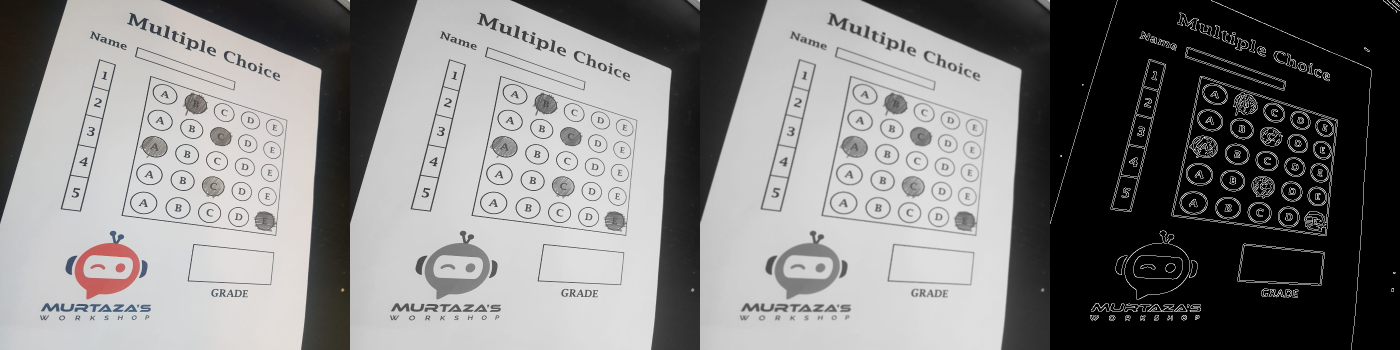

In [107]:
# Displaying Stack Of Images
imgArray = [image2,gray_image2,gray_blur_image2,gray_blur_canny_image2]
image_stackes = stackImages(imgArray,0.5)
cv2_imshow(image_stackes)

In [115]:
# Displaying the countour
contour_color_image1 = image2.copy()
imgBigContour = image2.copy()
biggest_contour_color_image1 = image2.copy()
contours,hierarchy = cv2.findContours(gray_blur_canny_image2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
cv2.drawContours(contour_color_image1,contours,-1,(0,255,0),10)
rectCon = rectContour(contours) # FILTER FOR RECTANGLE CONTOURS
biggestPoints = getCornerPoints(rectCon[0]) # GET CORNER POINTS OF THE BIGGEST RECTANGLE
gradePoints = getCornerPoints(rectCon[1]) # GET CORNER POINTS OF THE SECOND BIGGEST RECTANGLE

In [116]:
biggestPoints = reorder(biggestPoints) # REORDER FOR WARPING
cv2.drawContours(imgBigContour, biggestPoints, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
pts1 = np.float32(biggestPoints) # PREPARE POINTS FOR WARP
pts2 = np.float32([[0, 0],[700, 0], [0, 700],[700, 700]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2) # GET TRANSFORMATION MATRIX
imgWarpColored = cv2.warpPerspective(image2, matrix, (700, 700)) # APPLY WARP PERSPECTIVE

[[300 152]
 [243 431]
 [552 471]
 [574 239]]
[ 452  674 1023  813]
2


In [117]:
cv2.drawContours(imgBigContour, gradePoints, -1, (255, 0, 0), 20) # DRAW THE BIGGEST CONTOUR
gradePoints = reorder(gradePoints) # REORDER FOR WARPING
ptsG1 = np.float32(gradePoints)  # PREPARE POINTS FOR WARP
ptsG2 = np.float32([[0, 0], [325, 0], [0, 150], [325, 150]])  # PREPARE POINTS FOR WARP
matrixG = cv2.getPerspectiveTransform(ptsG1, ptsG2)# GET TRANSFORMATION MATRIX
imgGradeDisplay = cv2.warpPerspective(image2, matrixG, (325, 150)) # APPLY WARP PERSPECTIVE

[[386 488]
 [375 562]
 [542 570]
 [548 504]]
[ 874  937 1112 1052]
2


In [118]:
imgWarpGray = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY) # CONVERT TO GRAYSCALE
imgThresh = cv2.threshold(imgWarpGray, 170, 255,cv2.THRESH_BINARY_INV )[1] # APPLY THRESHOLD AND INVERSE

In [ ]:
cv2_imshow(imgWarpGray)
cv2_imshow(imgThresh)

Split Test


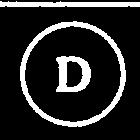

In [128]:
questions = 5
choices = 5
boxes = splitBoxes(imgThresh) # GET INDIVIDUAL BOXES
print('Split Test')
cv2_imshow(boxes[3])
countR=0
countC=0
myPixelVal = np.zeros((questions,choices)) # TO STORE THE NON ZERO VALUES OF EACH BOX
for image in boxes:
  totalPixels = cv2.countNonZero(image)
  myPixelVal[countR][countC]= totalPixels
  countC += 1
  if (countC==choices):
    countC=0;countR +=1